In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kstest, gennorm
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
wti = yf.download('CL=F', start='2000-01-01', end='2023-12-31')
wti['Date'] = pd.to_datetime(wti.index)
wti['Year'] = wti['Date'].dt.year
wti = wti.set_index('Date')   
wti['Daily_Return'] = wti['Adj Close'].pct_change()

[*********************100%%**********************]  1 of 1 completed


In [3]:
wti.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Year,Daily_Return
Date,,,,,,,,
2023-12-15,71.610001,72.220001,70.300003,71.430000,71.430000,95513,2023,-0.002096
2023-12-18,71.680000,74.260002,70.639999,72.470001,72.470001,73941,2023,0.014560
2023-12-19,72.480003,74.010002,71.849998,73.440002,73.440002,230042,2023,0.013385
2023-12-20,74.059998,75.370003,73.599998,74.220001,74.220001,273364,2023,0.010621
2023-12-21,73.809998,74.580002,72.440002,73.889999,73.889999,251982,2023,-0.004446
2023-12-22,73.910004,74.980003,73.389999,73.559998,73.559998,222600,2023,-0.004466
2023-12-26,73.559998,76.180000,73.129997,75.570000,75.570000,208715,2023,0.027325
2023-12-27,75.320000,75.660004,73.769997,74.110001,74.110001,253323,2023,-0.019320
2023-12-28,73.800003,74.400002,71.720001,71.769997,71.769997,262748,2023,-0.031575


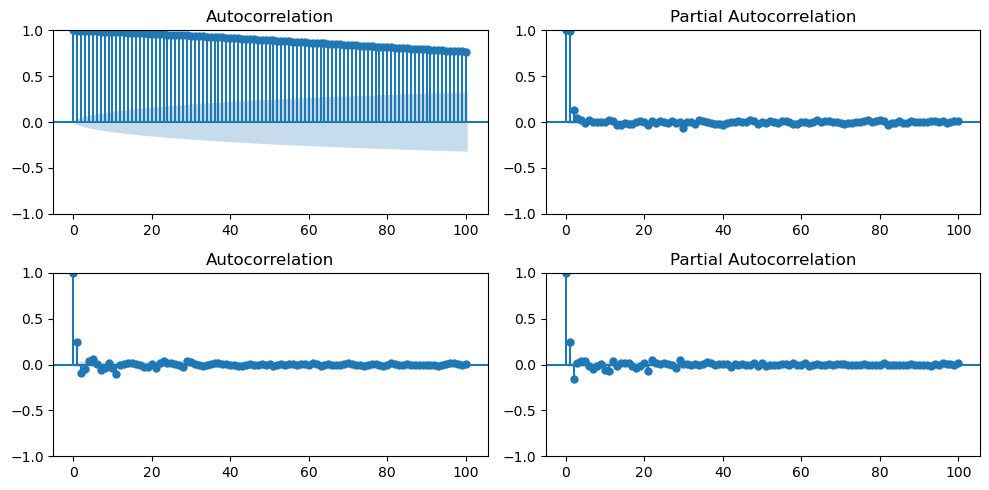

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
plot_acf(wti['Close'].dropna(), ax=axs[0,0], lags=100)
plot_pacf(wti['Close'].dropna(), ax=axs[0,1], lags=100)
plot_acf(wti['Daily_Return'].dropna(), ax=axs[1,0], lags=100)
plot_pacf(wti['Daily_Return'].dropna(), ax=axs[1,1], lags=100)
plt.tight_layout(); plt.show()

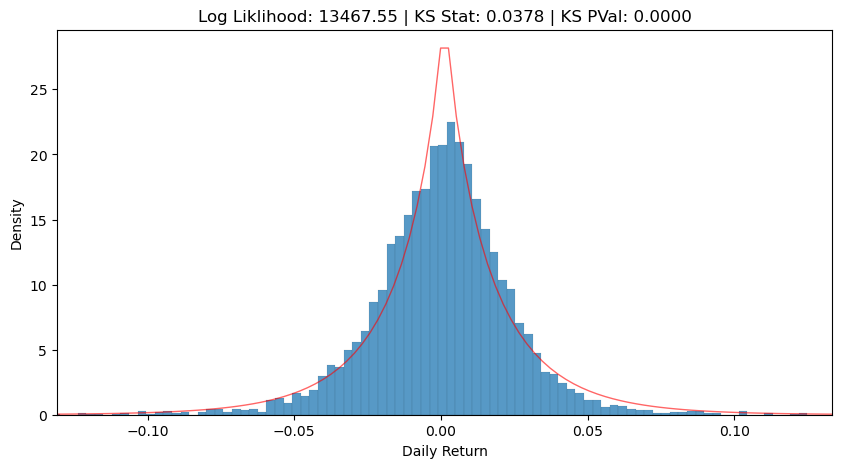

In [5]:
params = gennorm.fit(wti['Daily_Return'].dropna())
log_likelihood = gennorm.logpdf(wti['Daily_Return'].dropna(), *params).sum()
ks_stat, ks_stat_pval = kstest(wti['Daily_Return'].dropna(), 'gennorm', params)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(wti['Daily_Return'].dropna(), kde=False, stat='density', ax=ax)
x = np.linspace(gennorm.ppf(0.001, params[0], params[1], params[2]), 
                    gennorm.ppf(0.999, params[0], params[1], params[2]), 
                    100)
ax.plot(x, gennorm.pdf(x, params[0], params[1], params[2]), 'r-', 
                lw=1, alpha=0.6, label='GED fit')
ax.set(title=f'Log Liklihood: {log_likelihood:.2f} | KS Stat: {ks_stat:.4f} | KS PVal: {ks_stat_pval:.4f}',
       xlabel='Daily Return', ylabel='Density', xlim=(np.min(x), np.max(x)))
plt.show()  

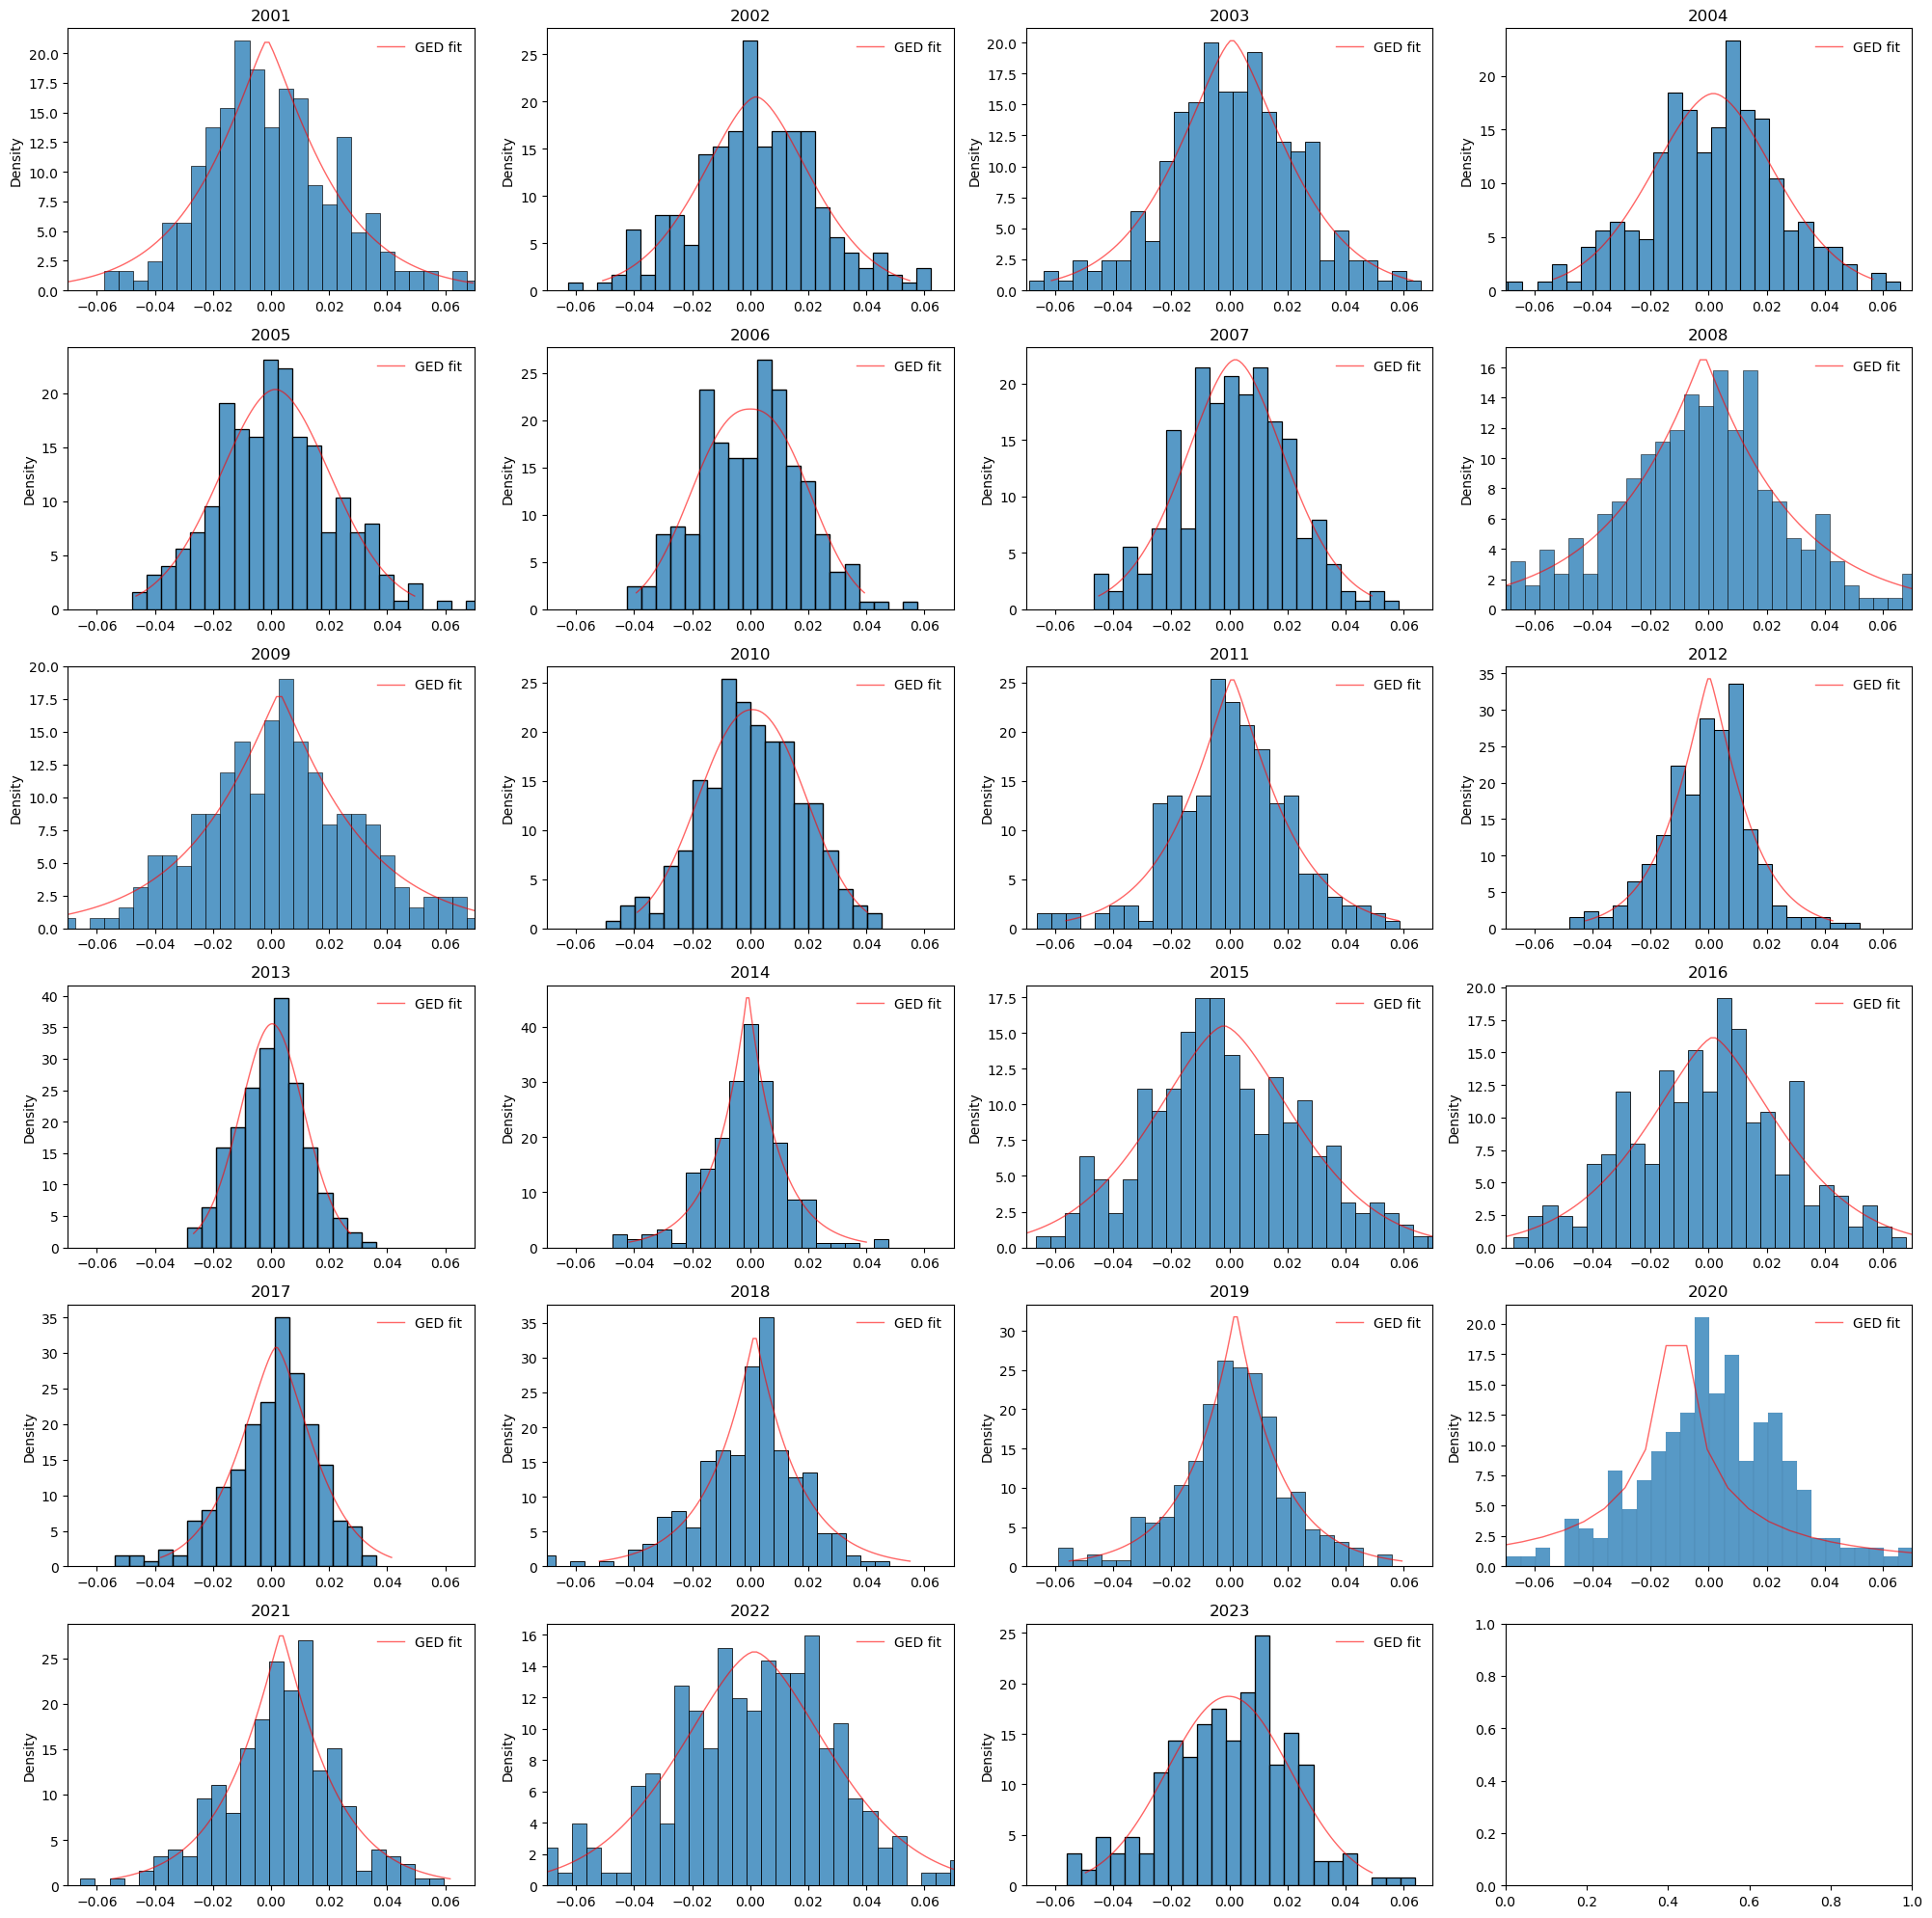

In [6]:
years = range(2001, 2024)
distributions = pd.DataFrame(index=years, columns=['Beta', 'Loc', 'Scale', 
                                                   'Median', 'Mean', 'Std',
                                                   'Log_Likelihood', 'KS_Stat', 'KS_Pval']) 
fig, axs = plt.subplots(nrows=(len(years)+1)//4, ncols=4, figsize=(20, 20))
for i, y in enumerate(years):
    ax = axs[i//4, i%4]
    data = wti.loc[(wti['Year'] == y), 'Daily_Return']
    data = np.where((data == np.inf) | (data == -np.inf), np.nan, data)
    data = data[~np.isnan(data)]
    params = gennorm.fit(data)
    log_likelihood = gennorm.logpdf(data, beta=params[0], loc=params[1], scale=params[2]).sum()
    ks_stat, ks_stat_pval = kstest(data, 'gennorm', args=(params[0], params[1], params[2]))
    distributions.loc[y] = [params[0], params[1], params[2],
                            np.median(data), np.mean(data), np.std(data),
                            log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=ax, stat='density', binwidth=0.005)
    x = np.linspace(gennorm.ppf(0.01, params[0], params[1], params[2]), 
                    gennorm.ppf(0.99, params[0], params[1], params[2]), 
                    100)
    ax.plot(x, gennorm.pdf(x, params[0], params[1], params[2]), 'r-', 
                lw=1, alpha=0.6, label='GED fit')
    ax.set(title=y, xlim=(-0.07, 0.07))  
    ax.legend(loc='best', frameon=False)
plt.tight_layout(); plt.show()
    
    

In [7]:
distributions

,Beta,Loc,Scale,Median,Mean,Std,Log_Likelihood,KS_Stat,KS_Pval
2001,1.214677,-0.001413,0.025153,-0.002541,-0.000833,0.027459,550.960182,0.042221,0.754274
2002,1.656432,0.002058,0.027306,0.001521,0.002047,0.021678,603.980142,0.023322,0.99879
2003,1.419138,0.000918,0.027171,0.000991,0.000473,0.024673,575.661775,0.031045,0.963374
2004,1.794963,0.001637,0.030592,0.003104,0.00143,0.023015,586.137107,0.040139,0.801903
2005,1.870565,0.001457,0.027648,0.001322,0.00156,0.020283,622.332891,0.042405,0.740957
2006,2.348707,0.000039,0.026623,0.001734,0.000154,0.017522,656.978984,0.046143,0.644308
2007,1.733375,0.002039,0.02536,0.002318,0.001987,0.01952,634.988308,0.029836,0.973477
2008,1.061082,-0.001846,0.030122,-0.001498,-0.002264,0.039217,478.224241,0.035345,0.898773
2009,1.125196,0.002791,0.028902,0.002926,0.002876,0.034339,505.242415,0.027767,0.987187
2010,2.148415,0.000705,0.025358,0.000119,0.00071,0.017318,664.6578,0.035666,0.894087


In [16]:
simulations = pd.DataFrame(index=years, columns=['Sim_Pct_Return', 'Sum_Cum_Return', 'Sim_Prices'])
for y in years[1:]:
    last_price = wti.loc[(wti['Year'] == y-1), 'Close'].iloc[-1]
    pct_return = gennorm.rvs(beta=distributions.loc[y-1, 'Beta'], 
                             loc=distributions.loc[y-1, 'Loc'],
                             scale=distributions.loc[y-1, 'Scale'],
                             size=(wti.loc[(wti['Year'] == y), 'Close'].shape[0], 100)) 
    cum_return = np.cumsum(pct_return, axis=1)
    sim_prices = last_price * (1 + cum_return)
    pass
    

NameError: name 'pct_retur' is not defined

In [12]:
simulations.head()

,Sim_Pct_Return,Sum_Cum_Return,Sim_Prices
2001,NaN,NaN,NaN
2002,NaN,NaN,NaN
2003,NaN,NaN,NaN
2004,NaN,NaN,NaN
2005,NaN,NaN,NaN
